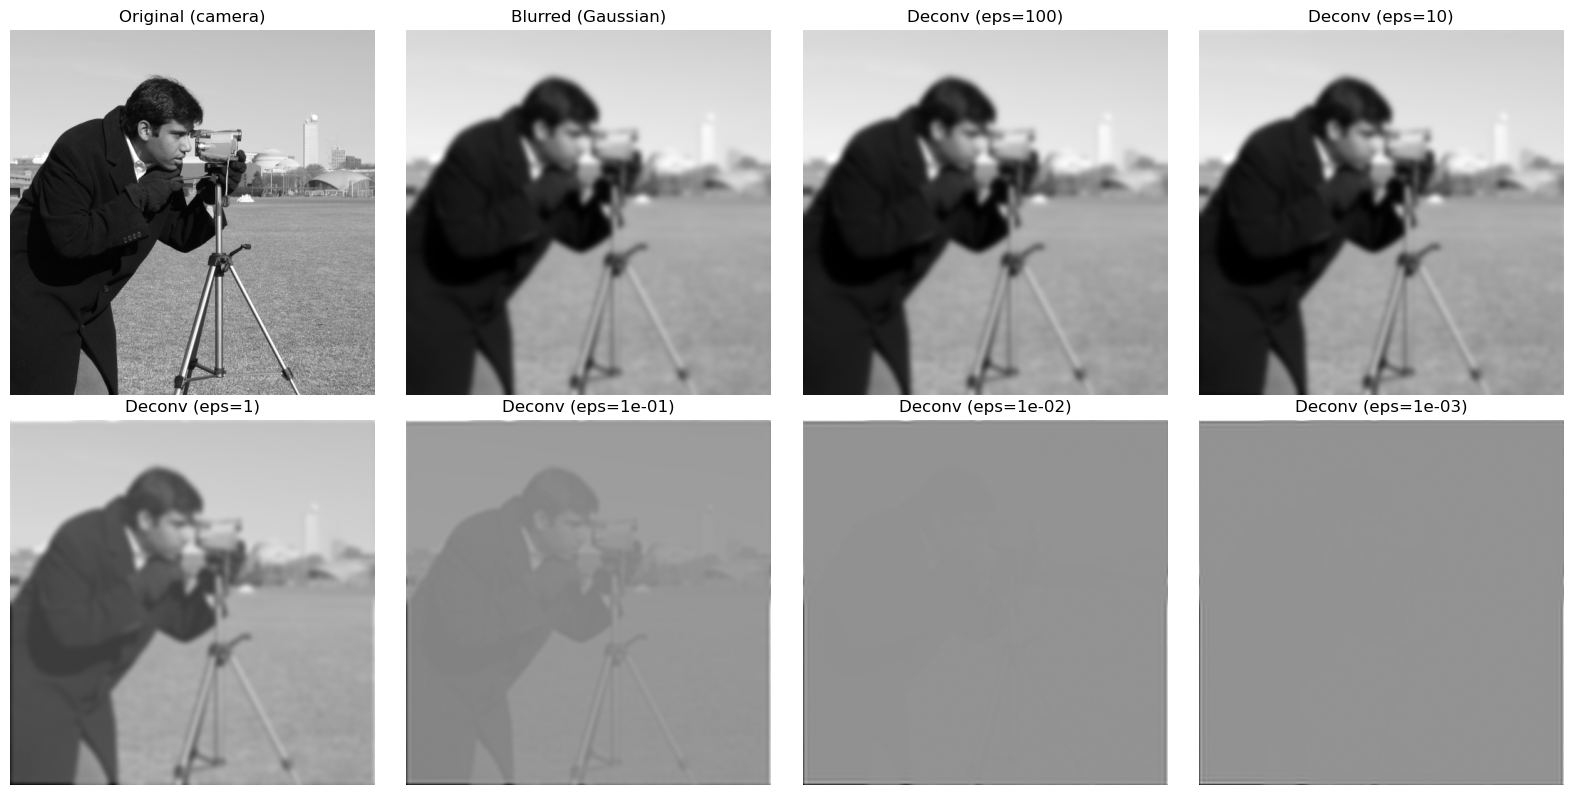

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from scipy.ndimage import gaussian_filter
from skimage import data, color

# ----------------------------
# 1. Load a grayscale image from skimage
# ----------------------------
img = data.camera()  # 512x512 grayscale image
img = img.astype(float) / 255.0  # Normalize to [0, 1]

H, W = img.shape

# ----------------------------
# 2. Gaussian blur (convolution)
# ----------------------------
sigma = 4.0
blurred = gaussian_filter(img, sigma=sigma)

# ----------------------------
# 3. FFTs
# ----------------------------
F_img = np.fft.fft2(img)
F_blur = np.fft.fft2(blurred)

# Gaussian PSF in spatial domain
psf = np.zeros_like(img)
psf[H//2, W//2] = 1
psf = gaussian_filter(psf, sigma=sigma)
psf /= psf.sum()

F_psf = np.fft.fft2(np.fft.ifftshift(psf))

# ----------------------------
# 4. Loop over different eps values
# ----------------------------
eps_values = [100, 10, 1, 1e-1, 1e-2, 1e-3]

# ----------------------------
# 5. Plot results
# ----------------------------
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
axs = axs.flatten()

# First show original and blurred
axs[0].imshow(img, cmap="gray")
axs[0].set_title("Original (camera)")
axs[0].axis("off")

axs[1].imshow(blurred, cmap="gray")
axs[1].set_title("Blurred (Gaussian)")
axs[1].axis("off")

# Loop through eps values and show deconvolution results
for i, eps in enumerate(eps_values):
    F_deconv = F_blur / (F_psf + eps)
    deconv = np.real(np.fft.ifft2(F_deconv))
    
    axs[i+2].imshow(deconv, cmap="gray")
    axs[i+2].set_title(f"Deconv (eps={eps:.0e})" if eps < 1 else f"Deconv (eps={eps:.0f})")
    axs[i+2].axis("off")

# Turn off the last unused subplot
if len(eps_values) < 7:
    for j in range(len(eps_values)+2, 8):
        axs[j].axis("off")

plt.tight_layout()
plt.show()


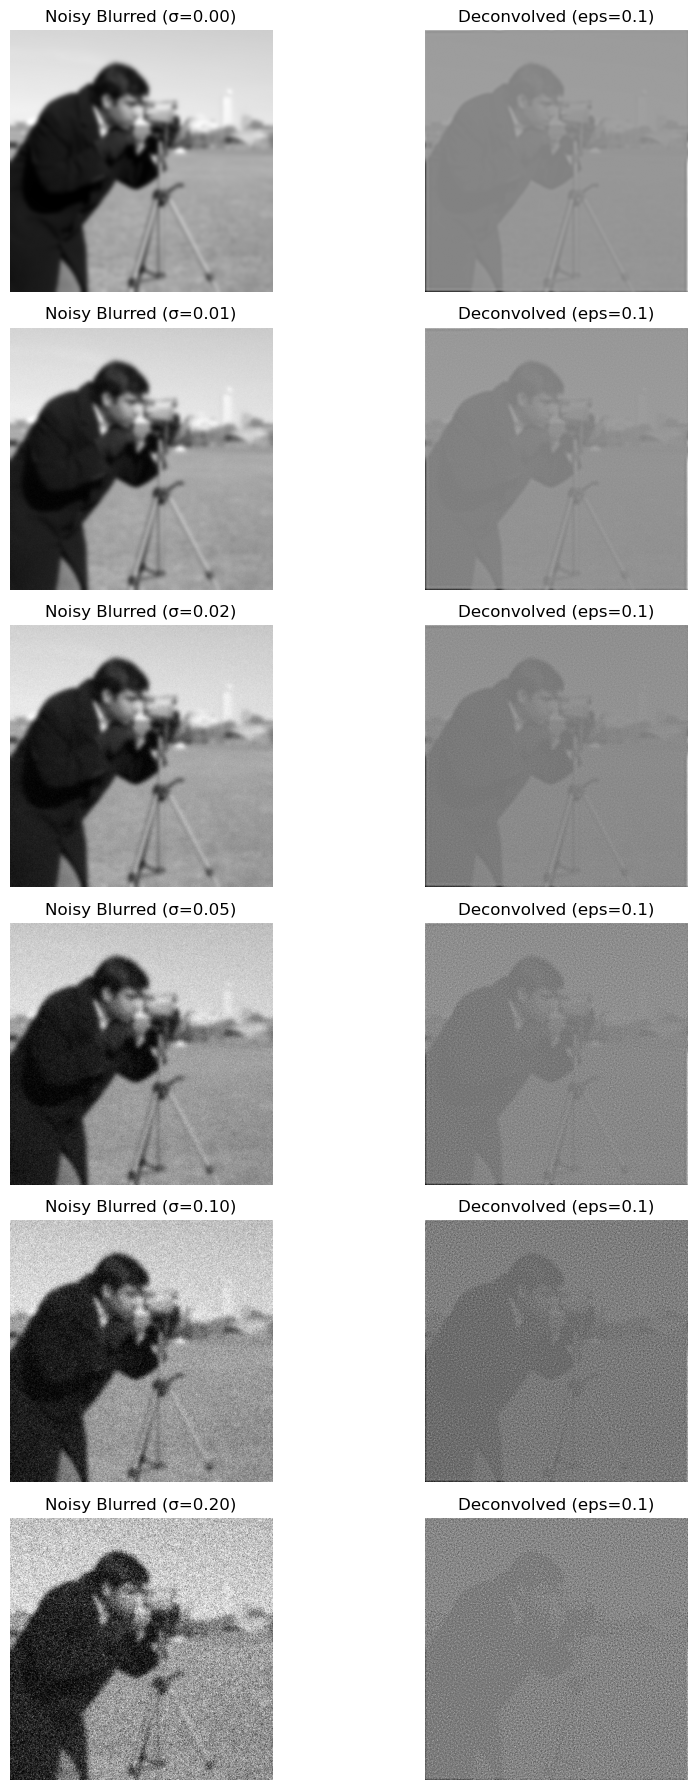

In [12]:
# ----------------------------
# Test different noise levels with fixed eps=1
# ----------------------------
noise_levels = [0, 0.01, 0.02, 0.05, 0.1, 0.2]
eps = 0.1

fig, axs = plt.subplots(6, 2, figsize=(10, 18))

for i, noise_level in enumerate(noise_levels):
    # Add Gaussian noise to blurred image
    noisy_blurred = blurred + np.random.normal(0, noise_level, blurred.shape)
    noisy_blurred = np.clip(noisy_blurred, 0, 1)
    
    # FFT of noisy blurred image
    F_noisy_blur = np.fft.fft2(noisy_blurred)
    
    # Deconvolve with eps=1
    F_deconv = F_noisy_blur / (F_psf + eps)
    deconv = np.real(np.fft.ifft2(F_deconv))
    
    # Left: noisy blurred
    axs[i, 0].imshow(noisy_blurred, cmap="gray")
    axs[i, 0].set_title(f"Noisy Blurred (σ={noise_level:.2f})")
    axs[i, 0].axis("off")
    
    # Right: deconvolved
    axs[i, 1].imshow(deconv, cmap="gray")
    axs[i, 1].set_title(f"Deconvolved (eps={eps})")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()
